In [12]:
#Customer segmentation
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
import seaborn as sns

customers_df=pd.read_csv('Customers Data.csv')
transactions_df=pd.read_csv('Transactions.csv')
products_df=pd.read_csv('Products.csv')


In [13]:
#first we need to create some features so we can segment/ cluster customer data.
customers_df['SignupDate'] = pd.to_datetime(customers_df['SignupDate'])
transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])
current_date = transactions_df['TransactionDate'].max()
#considering recency,frequency and money features first
rfm = transactions_df.groupby('CustomerID').agg({
        'TransactionDate': lambda x: (current_date - x.max()).days,  
        'TransactionID': 'count',                                    
        'TotalValue': ['sum', 'mean', 'std']                        
    })
# flatten column names
rfm.columns = ['Recency', 'Frequency', 'TotalSpend', 'AvgSpend', 'StdSpend']
#next to consider is category preferences
tx_with_products = transactions_df.merge(products_df, on='ProductID')
category_preferences = pd.crosstab(
        tx_with_products['CustomerID'], 
        tx_with_products['Category'],
        values=tx_with_products['TotalValue'],
        aggfunc='sum',
        normalize='index'
    ).fillna(0)
    
    #purchase features
purchase_patterns = transactions_df.groupby('CustomerID').agg({
        'Quantity': ['mean', 'std'],
        'TransactionDate': lambda x: x.dt.hour.mean()  # Average purchase hour
    })
purchase_patterns.columns = ['AvgQuantity', 'StdQuantity', 'AvgPurchaseHour']
# combine all features
features = rfm.join([category_preferences, purchase_patterns]).fillna(0)

Clusters: 2, DB Index: 2.213
Clusters: 3, DB Index: 2.075
Clusters: 4, DB Index: 2.111
Clusters: 5, DB Index: 1.884
Clusters: 6, DB Index: 1.772
Clusters: 7, DB Index: 1.719
Clusters: 8, DB Index: 1.613
Clusters: 9, DB Index: 1.612
Clusters: 10, DB Index: 1.604
Clusters: 11, DB Index: 1.596
Clusters: 12, DB Index: 1.651
Clusters: 13, DB Index: 1.543
Clusters: 14, DB Index: 1.534
Clusters: 15, DB Index: 1.433


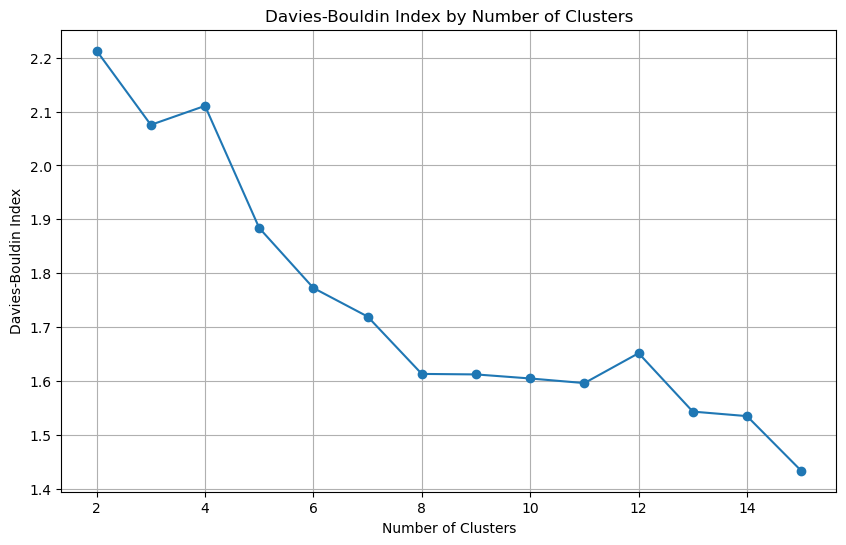

15
[2.213111714648523, 2.0754201807888593, 2.1107002940764144, 1.8838607178403408, 1.7724227455115713, 1.7193746198889621, 1.6128447098560454, 1.6119130099239254, 1.6043834153261867, 1.5958305643153727, 1.651329019497241, 1.5428724589910074, 1.5344755904159968, 1.4330593719690308]


In [14]:
#to perform clustering, we first need to find optimal amount of clusters we can use to perform perfect segmentation.
# we can use DB Indexing , so minimum db index is most efficient
#Find optimal number of clusters using DB Index
# Scale features
max_clusters=15
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
# Calculate DB Index for different numbers of clusters
db_scores = []
for n_clusters in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(scaled_features)
    db_score = davies_bouldin_score(scaled_features, cluster_labels)
    db_scores.append(db_score)
    print(f"Clusters: {n_clusters}, DB Index: {db_score:.3f}")
plt.figure(figsize=(10, 6))
plt.plot(range(2, max_clusters + 1), db_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Davies-Bouldin Index')
plt.title('Davies-Bouldin Index by Number of Clusters')
plt.grid(True)
plt.show()
optimal_clusters = db_scores.index(min(db_scores)) + 2
print(optimal_clusters)
print(db_scores)



Cluster Sizes:
Cluster
0     34
1     21
2      3
3     16
4     18
5     10
6      3
7     14
8     22
9     16
10    18
11    18
12     3
13     2
14     1
Name: count, dtype: int64

Cluster Profiles:
            Recency  Frequency   TotalSpend    AvgSpend    StdSpend     Books  \
Cluster                                                                         
0         40.617647   8.205882  6091.503235  749.997449  496.737527  0.307034   
1         46.857143   4.238095  2569.656667  606.141175  336.019637  0.100168   
2        280.333333   1.333333   409.796667  280.931667   32.024866  0.000000   
3         52.875000   3.875000  2084.043750  534.705021  405.644482  0.201221   
4         71.166667   4.888889  4116.035556  868.852041  598.197576  0.266876   
5         74.100000   3.200000  2571.961000  823.757900  297.913457  0.413926   
6        240.333333   1.000000   369.773333  369.773333    0.000000  0.000000   
7         74.928571   5.928571  2455.401429  409.835420  298.039887

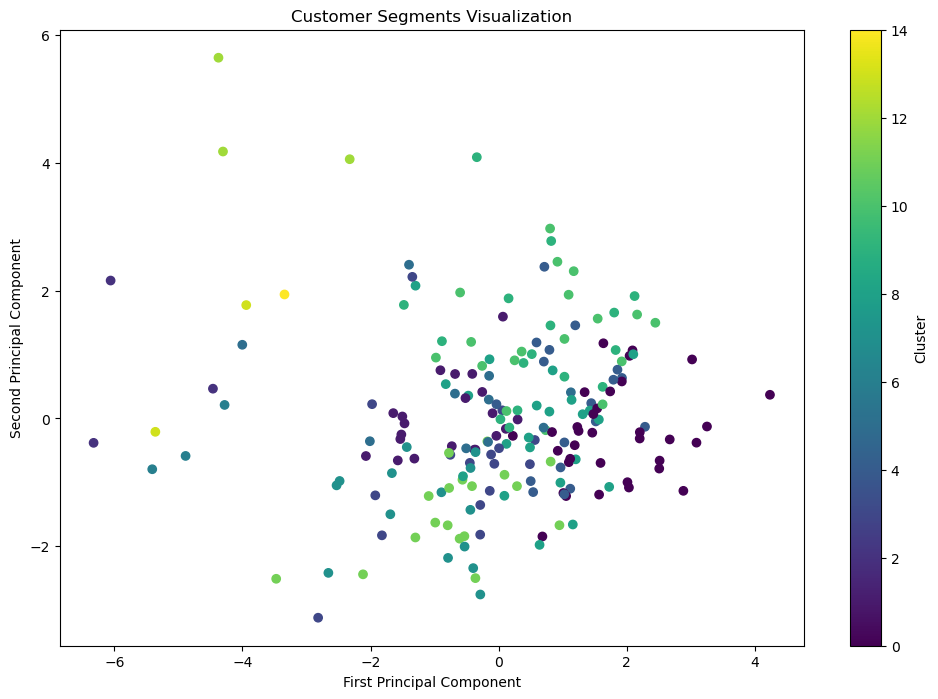

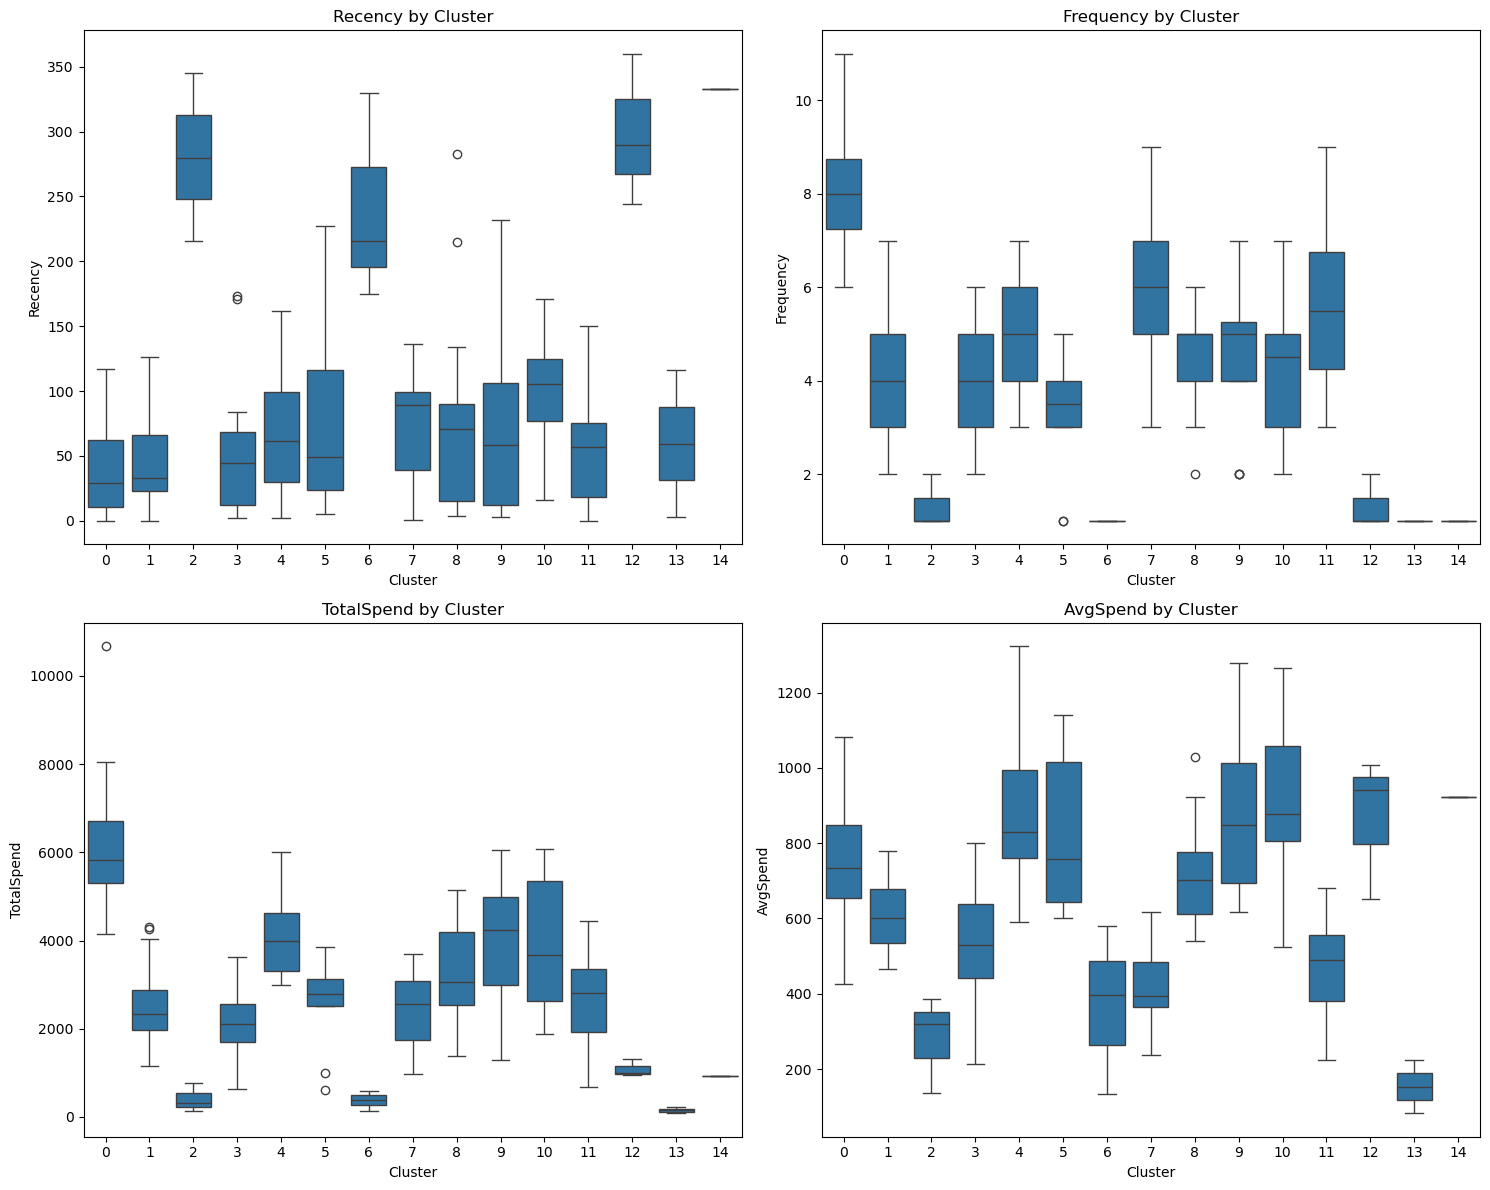

In [15]:
#Perform clustering with the optimal number of clusters
# scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
# perform K-means clustering
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_features)
clustered_data = features.copy()
clustered_data['Cluster'] = cluster_labels
print("\nCluster Sizes:")
print(clustered_data['Cluster'].value_counts().sort_index())
cluster_profiles = clustered_data.groupby('Cluster').mean()
print("\nCluster Profiles:")
print(cluster_profiles)
# visualizations
# PCA for dimensionality reduction
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_features = pca.fit_transform(StandardScaler().fit_transform(
        clustered_data.drop('Cluster', axis=1)
    ))
# Plot clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(pca_features[:, 0], pca_features[:, 1], c=clustered_data['Cluster'], cmap='viridis')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('Customer Segments Visualization')
plt.colorbar(scatter, label='Cluster')
plt.show()
# Key metrics by cluster
metrics = ['Recency', 'Frequency', 'TotalSpend', 'AvgSpend']
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
for i, metric in enumerate(metrics):
    ax = axes[i//2, i%2]
    sns.boxplot(data=clustered_data, x='Cluster', y=metric, ax=ax)
    ax.set_title(f'{metric} by Cluster')
plt.tight_layout()
plt.show()

In [17]:
customer_segments = customers_df[customers_df['CustomerID'].isin(features.index)].copy()
customer_segments['Cluster'] = cluster_labels
metrics_to_include = ['Recency', 'Frequency', 'TotalSpend', 'AvgSpend', 'AvgQuantity']
for metric in metrics_to_include:
    customer_segments[metric] = features[metric]
customer_segments.to_csv('customer_segments.csv', index=False)
print(f"Saved segmented customer data with {optimal_clusters} clusters")
print("\nCluster sizes:")
print(customer_segments['Cluster'].value_counts().sort_index())
excluded_customers = customers_df[~customers_df['CustomerID'].isin(features.index)]
if len(excluded_customers) > 0:
    print(f"\nNote: {len(excluded_customers)} customers were excluded (no transaction data)")

Saved segmented customer data with 15 clusters

Cluster sizes:
Cluster
0     34
1     21
2      3
3     16
4     18
5     10
6      3
7     14
8     22
9     16
10    18
11    18
12     3
13     2
14     1
Name: count, dtype: int64

Note: 1 customers were excluded (no transaction data)
